# Homework: Build Your Own Segmentation Model with ConvNeXt

In this assignment, you will build an image segmentation model that uses a provided ConvNeXt layer as the backbone (encoder). Your challenge is to design and implement the segmentation head (decoder) in any way you prefer. This task gives you the flexibility to experiment with different architectural ideas while learning how to repurpose modern convolutional blocks for dense prediction tasks.

## Overview

- **Task:**  
  Use the provided ConvNeXt layer to extract features from the input images, then design your own segmentation decoder to output pixel-wise predictions (segmentation masks).

- **Dataset:**  
  We'll use the Oxford-IIIT Pet dataset (which contains images along with pixel-level segmentation masks). This dataset is easy to download via PyTorch's `torchvision` library.

- **Goal:**  
  Design a segmentation model that can accurately separate the pet from the background (or other semantic regions) in the images. Experiment with different decoder architectures, upsampling techniques, and loss functions.

## Provided ConvNeXt Layer

Below is a simplified ConvNeXt layer that you will use as the building block of your encoder. Feel free to experiment with it or use it as is:


## Your Tasks

### 1. Data Exploration and Preprocessing

- **Download the Dataset:**  
  Use PyTorch's `torchvision.datasets.OxfordIIITPet` to download the dataset with segmentation masks.
- **Visualize the Data:**  
  Explore the images and segmentation masks to understand the data distribution and check for any class imbalances.

#### Example Code to Download & Visualize:


Dataset size: 3680 samples


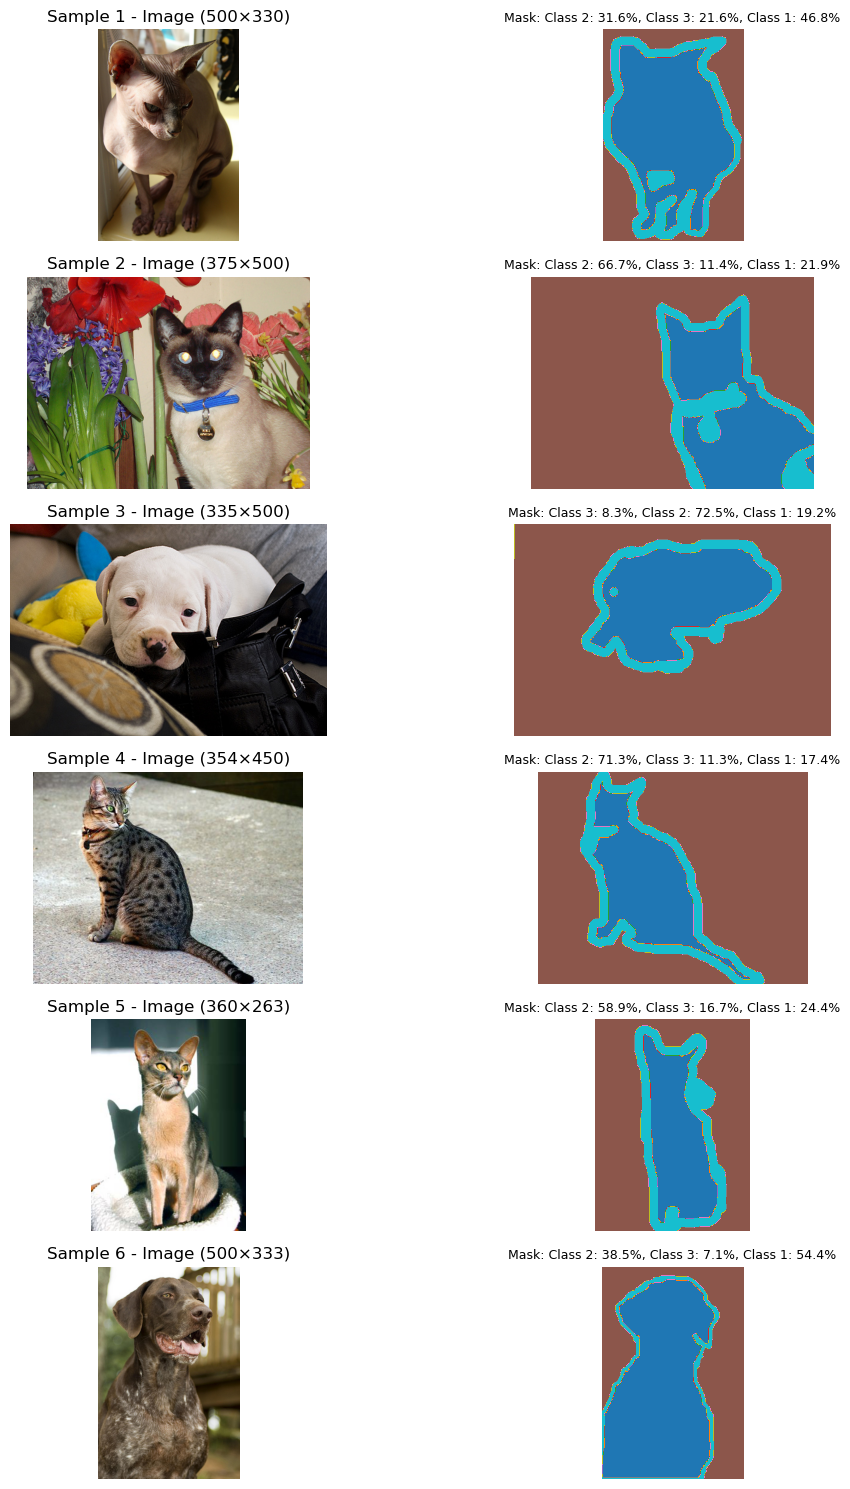

Analyzed 500 random samples (84990403 total pixels)

Global class distribution:
Class 1: 25038645 pixels (29.46%)
Class 2: 50693969 pixels (59.65%)
Class 3: 9257789 pixels (10.89%)

Image size distribution:
Found 156 unique image dimensions
500×375: 116 images (23.2%)
500×333: 68 images (13.6%)
375×500: 40 images (8.0%)
333×500: 31 images (6.2%)
300×225: 18 images (3.6%)
500×334: 17 images (3.4%)
334×500: 8 images (1.6%)
225×300: 7 images (1.4%)
332×500: 7 images (1.4%)
500×332: 6 images (1.2%)


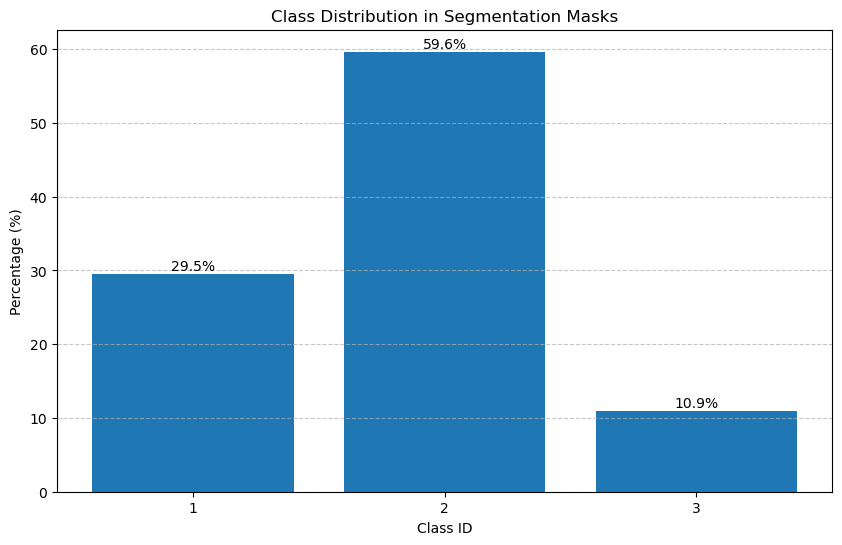


Oxford-IIIT Pet Dataset Information:
- Contains images of cats and dogs (37 breeds)
- Segmentation masks typically have 3 classes:
  - Class 0: Background
  - Class 1: Foreground (pet)
  - Class 2: Pet outline/boundary


In [69]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
from collections import Counter

# Define a transform to convert images to tensors
transform = transforms.ToTensor()

# Download the Oxford-IIIT Pet dataset with segmentation masks
dataset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='trainval',
    target_types='segmentation',
    download=True,
    transform=transform
)

# 1. Basic Dataset Information
print(f"Dataset size: {len(dataset)} samples")

# 2. Sample Visualization with Enhanced Information
num_samples = 6

plt.figure(figsize=(12, 15))
for i in range(num_samples):
    # Get a random sample
    idx = np.random.randint(0, len(dataset))
    image, mask = dataset[idx]

    # Calculate class distribution in this mask
    mask_np = np.array(mask)
    class_counts = Counter(mask_np.flatten())
    total_pixels = mask_np.size
    class_percentages = {k: (v/total_pixels)*100 for k,
                         v in class_counts.items()}

    # Get image dimensions
    c, h, w = image.shape

    # Image subplot
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f'Sample {i+1} - Image ({h}×{w})')
    plt.axis('off')

    # Mask subplot with class distribution
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(mask, cmap='tab10')
    title_text = f'Mask: ' + \
        ', '.join([f'Class {k}: {v:.1f}%' for k,
                  v in class_percentages.items()])
    plt.title(title_text, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

class_distribution = Counter()
mask_sizes = []

# Use a subset for faster analysis if dataset is large
sample_size = min(500, len(dataset))
indices = np.random.choice(len(dataset), sample_size, replace=False)

for idx in indices:
    _, mask = dataset[idx]
    mask_np = np.array(mask)
    mask_sizes.append(mask_np.size)
    class_distribution.update(mask_np.flatten())

total_pixels = sum(mask_sizes)
print(f"Analyzed {sample_size} random samples ({total_pixels} total pixels)")

print("\nGlobal class distribution:")
for class_id, count in sorted(class_distribution.items()):
    percentage = (count / total_pixels) * 100
    print(f"Class {class_id}: {count} pixels ({percentage:.2f}%)")

# 4. Image Size Distribution
print("\nImage size distribution:")
width_heights = []
for idx in indices:
    img, _ = dataset[idx]
    _, h, w = img.shape
    width_heights.append((w, h))

unique_sizes = Counter(width_heights)
print(f"Found {len(unique_sizes)} unique image dimensions")
for (w, h), count in unique_sizes.most_common(10):
    print(f"{w}×{h}: {count} images ({count/sample_size*100:.1f}%)")

# 5. Class Visualization
plt.figure(figsize=(10, 6))
class_ids = sorted(class_distribution.keys())
class_counts = [class_distribution[class_id] for class_id in class_ids]
class_percentages = [(count / total_pixels) * 100 for count in class_counts]

plt.bar([str(c) for c in class_ids], class_percentages)
plt.title('Class Distribution in Segmentation Masks')
plt.xlabel('Class ID')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(class_percentages):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')
plt.show()

# 6. Additional Information about the dataset
print("\nOxford-IIIT Pet Dataset Information:")
print("- Contains images of cats and dogs (37 breeds)")
print("- Segmentation masks typically have 3 classes:")
print("  - Class 0: Background")
print("  - Class 1: Foreground (pet)")
print("  - Class 2: Pet outline/boundary")

In [48]:
class OxfordPetSegmentation(torch.utils.data.Dataset):
    def __init__(self, dataset, image_size=256):
        self.dataset = dataset
        self.image_size = image_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]

        # Resize image and mask
        image = TF.resize(image, (self.image_size, self.image_size))
        mask = TF.resize(mask, (self.image_size, self.image_size),
                         interpolation=transforms.InterpolationMode.NEAREST)

        # Convert image to tensor and normalize
        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])

        # Convert mask to tensor (Oxford Pet masks have values 1=background, 2=pet, 3=boundary)
        # Adjust to 0-indexed for PyTorch (0=background, 1=pet, 2=boundary)
        mask = torch.from_numpy(np.array(mask)).long() - 1

        return image, mask

# Define metric functions


def pixel_accuracy(outputs, targets):
    """Compute pixel accuracy"""
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == targets).float()
    return correct.sum() / correct.numel()


def intersection_over_union(outputs, targets, num_classes):
    """Compute mean IoU across classes"""
    _, preds = torch.max(outputs, dim=1)
    ious = []

    for cls in range(num_classes):
        pred_mask = (preds == cls)
        target_mask = (targets == cls)
        intersection = (pred_mask & target_mask).sum().float()
        union = (pred_mask | target_mask).sum().float()
        if union > 0:
            iou = intersection / union
            ious.append(iou)

    return torch.tensor(ious).mean() if ious else torch.tensor(0.0)

### 2. Model Design and Implementation

Your challenge here is to design the **segmentation decoder** that complements the provided ConvNeXtLayer-based encoder. The key idea is to take the lower-resolution feature maps produced by the encoder and transform them into full-resolution segmentation maps.

#### What You Need to Achieve

- **Input:**  
  The encoder (which you will build by stacking one or more `ConvNeXtLayer`s) takes an image of shape `[B, 3, H, W]` and outputs a feature map. For example, after two layers you might have features of shape `[B, 128, H_enc, W_enc]` where `H_enc` and `W_enc` are downsampled versions of `H` and `W`.

- **Output:**  
  Your segmentation decoder must transform the encoder output into a segmentation mask with shape `[B, num_classes, H, W]`, where `num_classes` is the number of segmentation labels (e.g., 2 for binary segmentation like pet vs. background).

#### Hints for Building Your Decoder

1. **Upsampling:**

   - **Transposed Convolutions:**  
     You can use layers like `nn.ConvTranspose2d` to upsample the feature maps gradually.
   - **Interpolation + Convolution:**  
     Another approach is to upsample using `F.interpolate` (e.g., bilinear interpolation) and follow up with a convolution layer (`nn.Conv2d`) to refine the features.

2. **Skip Connections:**

   - To help recover spatial details lost during downsampling, consider adding skip connections from early encoder layers to corresponding decoder layers.

3. **Layer Organization:**
   - Organize your decoder in stages. For example:
     - **Stage 1:** Upsample features (e.g., from `[B, 128, H_enc, W_enc]` to `[B, 64, H_enc*2, W_enc*2]`).
     - **Stage 2:** Further process and upsample until you reach the original resolution `[B, num_classes, H, W]`.

#### Pseudo-Code Example (Skeleton)

Below is a pseudo-code outline to guide you. **Note:** Do not use this code verbatim—use it as a reference to design your own decoder.


In [49]:
class ConvNeXtLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1, padding=3):
        super(ConvNeXtLayer, self).__init__()
        # Depthwise Convolution
        self.dwconv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                stride=stride, padding=padding, groups=in_channels)
        # Layer Normalization
        self.norm = nn.LayerNorm(in_channels)  # Normalize over channels only
        # Activation
        self.activation = nn.GELU()
        # Pointwise Convolution
        self.pwconv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = x
        x = self.dwconv(x)

        # Permute to [B, H, W, C] for LayerNorm
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)  # Apply normalization over last dimension (channels)
        x = x.permute(0, 3, 1, 2)  # Back to [B, C, H, W]

        x = self.activation(x)
        x = self.pwconv(x)
        return x


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(EncoderBlock, self).__init__()
        self.downsample = downsample

        self.conv = ConvNeXtLayer(in_channels, out_channels)

        if downsample:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        if self.downsample:
            # Return both downsampled and original for skip connections
            return self.pool(x), x
        return x, x

# Decoder block for upsampling


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=True):
        super(DecoderBlock, self).__init__()

        # For upsampling path, the input to the upsample is just the bottleneck features
        # not the concatenated ones
        if upsample:
            self.upsample = nn.ConvTranspose2d(
                in_channels // 2, in_channels // 4, kernel_size=2, stride=2)
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels // 4 + in_channels // 2,
                          out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.upsample = nn.Identity()
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x, skip=None):
        x = self.upsample(x)

        if skip is not None:
            # Ensure the spatial dimensions match
            if x.shape[2:] != skip.shape[2:]:
                x = F.interpolate(
                    x, size=skip.shape[2:], mode='bilinear', align_corners=False)

            # Concatenate along channel dimension
            x = torch.cat([x, skip], dim=1)

        return self.conv(x)

# Complete Segmentation Model with ConvNeXt Encoder and UNet-style Decoder


class SegmentationModel1(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(SegmentationModel1, self).__init__()

        # Encoder pathway (downsampling)
        self.enc1 = EncoderBlock(
            in_channels, 64, downsample=True)     # 64x112x112
        self.enc2 = EncoderBlock(
            64, 128, downsample=True)             # 128x56x56
        self.enc3 = EncoderBlock(
            128, 256, downsample=True)            # 256x28x28
        self.enc4 = EncoderBlock(
            256, 512, downsample=True)            # 512x14x14

        # Bridge
        self.bridge = ConvNeXtLayer(
            512, 512)                          # 512x14x14

        # Decoder pathway (upsampling with skip connections)
        # Each decoder takes the upsampled features and concatenates with skip connection
        self.up4 = nn.ConvTranspose2d(
            512, 256, kernel_size=2, stride=2)  # 256x28x28
        self.dec4 = nn.Sequential(
            nn.Conv2d(256 + 512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.up3 = nn.ConvTranspose2d(
            256, 128, kernel_size=2, stride=2)  # 128x56x56
        self.dec3 = nn.Sequential(
            nn.Conv2d(128 + 256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.ConvTranspose2d(
            128, 64, kernel_size=2, stride=2)   # 64x112x112
        self.dec2 = nn.Sequential(
            nn.Conv2d(64 + 128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.ConvTranspose2d(
            64, 32, kernel_size=2, stride=2)    # 32x224x224
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Final layer
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder pathway with skip connections
        # 64x112x112
        x, skip1 = self.enc1(x)
        # 128x56x56
        x, skip2 = self.enc2(x)
        # 256x28x28
        x, skip3 = self.enc3(x)
        # 512x14x14
        x, skip4 = self.enc4(x)

        # Bridge
        # 512x14x14
        x = self.bridge(x)

        # Decoder pathway using skip connections
        # 256x28x28
        x = self.up4(x)
        # (256+512)x28x28
        x = torch.cat([x, skip4], dim=1)
        # 256x28x28
        x = self.dec4(x)

        # 128x56x56
        x = self.up3(x)
        # (128+256)x56x56
        x = torch.cat([x, skip3], dim=1)
        # 128x56x56
        x = self.dec3(x)

        # 64x112x112
        x = self.up2(x)
        # (64+128)x112x112
        x = torch.cat([x, skip2], dim=1)
        # 64x112x112
        x = self.dec2(x)

        # 32x224x224
        x = self.up1(x)
        # (32+64)x224x224
        x = torch.cat([x, skip1], dim=1)
        # 32x224x224
        x = self.dec1(x)

        # Final layer to get segmentation map
        # num_classesx224x224
        x = self.final(x)

        return x

### 3. Training and Evaluation

In this section, you'll set up your training loop, choose appropriate metrics, and evaluate your segmentation model. We'll use:

- **Loss Function:** `CrossEntropyLoss` (suitable for multi-class segmentation).
- **Metrics:**
  - **Pixel Accuracy:** The percentage of correctly predicted pixels.
  - **Intersection-over-Union (IoU):** The ratio of the intersection to the union of the predicted and ground truth regions for each class.

#### Metric Functions

Add these helper functions to compute Pixel Accuracy and Mean IoU:


# Training Loop Example

Below is an example training loop that uses the above metrics. This loop trains your model for a set number of epochs, prints the loss for each epoch, and evaluates the Pixel Accuracy and Mean IoU after each epoch.


## Deliverables

Please ensure that your final submission includes **all the components in a single Jupyter Notebook**. Your notebook should be well-organized, with clear headings, comments, and markdown cells that explain your work. Specifically, your submission should include:

1. **Data Exploration and Preprocessing**

   - Code to download and load the Oxford-IIIT Pet dataset.
   - Visualizations of sample images and their corresponding segmentation masks.
   - A brief analysis discussing any observations from the data (e.g., class imbalances, noise, etc.).

2. **Model Design and Implementation**

   - Your implementation of an encoder that uses the provided `ConvNeXtLayer`.
   - Your custom segmentation decoder design. Be sure to clearly explain:
     - The input and output shapes (e.g., encoder output of shape `[B, 128, H_enc, W_enc]` and desired decoder output of `[B, num_classes, H, W]`).
     - The architectural choices (e.g., upsampling methods, any skip connections, etc.).
     - How your design transforms low-resolution feature maps back to full-resolution segmentation maps.

3. **Training and Evaluation**

   - A complete training loop with:
     - The use of `CrossEntropyLoss` as your loss function.
     - An optimizer (e.g., Adam) and any learning rate adjustments.
   - Code to compute evaluation metrics:
     - **Pixel Accuracy**: The percentage of correctly predicted pixels.
     - **Intersection-over-Union (IoU)**: Mean IoU across classes.
   - Visualizations or printed outputs that demonstrate model performance over epochs.
   - A brief discussion of the results (e.g., trends in loss, pixel accuracy, and IoU).

4. **Overall Notebook Structure**
   - Clear organization with sections separated by markdown headings.
   - Inline comments explaining key parts of your code.
   - A summary or conclusion section reflecting on your experiments and results.

---

### Submission Instructions

- **Format:** Submit your work as a single Jupyter Notebook (e.g., `segmentation_homework.ipynb`).
- **Content:** The notebook must include all the code, visualizations, and explanations outlined above.


---


# 3 Training and Evaluation

- A complete training loop with:
  - The use of `CrossEntropyLoss` as your loss function.
  - An optimizer (e.g., Adam) and any learning rate adjustments.
- Code to compute evaluation metrics:
  - **Pixel Accuracy**: The percentage of correctly predicted pixels.
  - **Intersection-over-Union (IoU)**: Mean IoU across classes.
- Visualizations or printed outputs that demonstrate model performance over epochs.
- A brief discussion of the results (e.g., trends in loss, pixel accuracy, and IoU).

### **Trained on Google Colab for 15 epochs**


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f"Using device: {device}")

# Set random seed
torch.manual_seed(42)

# Hyperparameters
num_classes = 3  # Oxford Pet has 3 classes (background, pet, boundary)
batch_size = 8
learning_rate = 1e-4
num_epochs = 5  # Adjust as needed

# Download and load the Oxford-IIIT Pet dataset
print("Loading Oxford-IIIT Pet dataset...")
dataset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='trainval',
    target_types='segmentation',
    download=True
)

# Create custom dataset wrapper
oxford_dataset = OxfordPetSegmentation(dataset)

# Split dataset into train and validation sets
train_size = int(0.8 * len(oxford_dataset))
val_size = len(oxford_dataset) - train_size
train_dataset, val_dataset = random_split(
    oxford_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")

# Create data loaders (with num_workers=0 for notebooks)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

# Initialize model with the fixed implementation
model = SegmentationModel1(224, 3).to(device)
# model = SegmentationModel(in_channels=3, num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_batch_losses = []  # Track losses for this epoch

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        running_loss += loss.item()
        pbar.set_postfix({'batch_loss': f"{current_loss:.4f}",
                         'avg_loss': f"{running_loss/(i+1):.4f}"})

    avg_loss = running_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Evaluate the model
    model.eval()
    acc_total, iou_total, count = 0.0, 0.0, 0

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            # Compute Pixel Accuracy and Mean IoU
            acc = pixel_accuracy(outputs, masks)
            iou = intersection_over_union(outputs, masks, num_classes)

            acc_total += acc.item()
            iou_total += iou.item()
            count += 1

    avg_acc = acc_total / count
    avg_iou = iou_total / count
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Pixel Accuracy: {avg_acc:.4f}, Mean IoU: {avg_iou:.4f}")

Using device: cuda\
Loading Oxford-IIIT Pet dataset...\
Training samples: 2944\
Validation samples: 736
Epoch 1/15 - Training:   0%\
 0/368 [16:53<?, ?it/s, batch_loss=3.8277, avg_loss=16.0413]\
Epoch 1/15 - Training: 100%\
 368/368 [02:09<00:00,  2.87it/s]\
Epoch [1/15], Loss: 4.3591\
Epoch 1/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.93it/s]\
Epoch [1/15], Pixel Accuracy: 0.6945, Mean IoU: 0.4630\
Epoch 2/15 - Training:   0%\
 0/368 [14:31<?, ?it/s, batch_loss=2.4054, avg_loss=10.9320]\
Epoch 2/15 - Training: 100%\
 368/368 [02:10<00:00,  2.85it/s]\
Epoch [2/15], Loss: 2.9707\
Epoch 2/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.91it/s]\
Epoch [2/15], Pixel Accuracy: 0.6877, Mean IoU: 0.4586\
Epoch 3/15 - Training:   0%\
 0/368 [12:09<?, ?it/s, batch_loss=1.3404, avg_loss=6.4782]\
Epoch 3/15 - Training: 100%\
 368/368 [02:11<00:00,  2.74it/s]\
Epoch [3/15], Loss: 1.7604\
Epoch 3/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.62it/s]\
Epoch [3/15], Pixel Accuracy: 0.7441, Mean IoU: 0.4927\
Epoch 4/15 - Training:   0%\
 0/368 [09:44<?, ?it/s, batch_loss=0.8920, avg_loss=3.8970]\
Epoch 4/15 - Training: 100%\
 368/368 [02:13<00:00,  2.79it/s]\
Epoch [4/15], Loss: 1.0590\
Epoch 4/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.87it/s]\
Epoch [4/15], Pixel Accuracy: 0.7710, Mean IoU: 0.5198\
Epoch 5/15 - Training:   0%\
 0/368 [07:18<?, ?it/s, batch_loss=0.6389, avg_loss=2.8138]\
Epoch 5/15 - Training: 100%\
 368/368 [02:13<00:00,  2.79it/s]\
Epoch [5/15], Loss: 0.7646\
Epoch 5/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.69it/s]\
Epoch [5/15], Pixel Accuracy: 0.7907, Mean IoU: 0.5503\
Epoch 6/15 - Training:   0%\
 0/368 [04:52<?, ?it/s, batch_loss=0.5357, avg_loss=2.3304]\
Epoch 6/15 - Training: 100%\
 368/368 [02:13<00:00,  2.80it/s]\
Epoch [6/15], Loss: 0.6333\
Epoch 6/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.73it/s]\
Epoch [6/15], Pixel Accuracy: 0.7855, Mean IoU: 0.5541\
Epoch 7/15 - Training:   0%\
 0/368 [22:10<?, ?it/s, batch_loss=0.4842, avg_loss=2.0892]\
Epoch 7/15 - Training: 100%\
 368/368 [02:13<00:00,  2.55it/s]\
Epoch [7/15], Loss: 0.5677\
Epoch 7/15 - Validation: 100%\
 92/92 [00:12<00:00,  6.70it/s]\
Epoch [7/15], Pixel Accuracy: 0.7950, Mean IoU: 0.5627\
Epoch 8/15 - Training:   0%\
 0/368 [19:44<?, ?it/s, batch_loss=0.7882, avg_loss=1.9280]\
Epoch 8/15 - Training: 100%\
 368/368 [02:13<00:00,  2.70it/s]\
Epoch [8/15], Loss: 0.5239\
Epoch 8/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.80it/s]\
Epoch [8/15], Pixel Accuracy: 0.8078, Mean IoU: 0.5642\
Epoch 9/15 - Training:   0%\
 0/368 [17:17<?, ?it/s, batch_loss=0.5129, avg_loss=1.8137]\
Epoch 9/15 - Training: 100%\
 368/368 [02:14<00:00,  2.79it/s]\
Epoch [9/15], Loss: 0.4929\
Epoch 9/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.82it/s]\
Epoch [9/15], Pixel Accuracy: 0.8088, Mean IoU: 0.5750\
Epoch 10/15 - Training:   0%\
 0/368 [14:50<?, ?it/s, batch_loss=0.4768, avg_loss=1.7312]\
Epoch 10/15 - Training: 100%\
 368/368 [02:13<00:00,  2.80it/s]\
Epoch [10/15], Loss: 0.4704\
Epoch 10/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.76it/s]\
Epoch [10/15], Pixel Accuracy: 0.8066, Mean IoU: 0.5565\
Epoch 11/15 - Training:   0%\
 0/368 [12:24<?, ?it/s, batch_loss=0.4090, avg_loss=1.6515]\
Epoch 11/15 - Training: 100%\
 368/368 [02:13<00:00,  2.77it/s]\
Epoch [11/15], Loss: 0.4488\
Epoch 11/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.74it/s]\
Epoch [11/15], Pixel Accuracy: 0.8136, Mean IoU: 0.5672\
Epoch 12/15 - Training:   0%\
 0/368 [09:58<?, ?it/s, batch_loss=0.3646, avg_loss=1.5740]\
Epoch 12/15 - Training: 100%\
 368/368 [02:14<00:00,  2.80it/s]\
Epoch [12/15], Loss: 0.4277\
Epoch 12/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.73it/s]\
Epoch [12/15], Pixel Accuracy: 0.8152, Mean IoU: 0.5814\
Epoch 13/15 - Training:   0%\
 0/368 [07:32<?, ?it/s, batch_loss=0.3541, avg_loss=1.5036]\
Epoch 13/15 - Training: 100%\
 368/368 [02:14<00:00,  2.60it/s]\
Epoch [13/15], Loss: 0.4086\
Epoch 13/15 - Validation: 100%\
 92/92 [00:12<00:00,  6.39it/s]\
Epoch [13/15], Pixel Accuracy: 0.8102, Mean IoU: 0.5657\
Epoch 14/15 - Training:   0%\
 0/368 [05:04<?, ?it/s, batch_loss=0.4723, avg_loss=1.4425]\
Epoch 14/15 - Training: 100%\
 368/368 [02:14<00:00,  2.72it/s]\
Epoch [14/15], Loss: 0.3920\
Epoch 14/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.71it/s]\
Epoch [14/15], Pixel Accuracy: 0.8162, Mean IoU: 0.5780\
Epoch 15/15 - Training:   0%\
 0/368 [02:14<?, ?it/s, batch_loss=0.3314, avg_loss=1.3630]\
Epoch 15/15 - Training: 100%\
 368/368 [02:14<00:00,  2.79it/s]\
Epoch [15/15], Loss: 0.3704\
Epoch 15/15 - Validation: 100%\
 92/92 [00:12<00:00,  7.65it/s]\
Epoch [15/15], Pixel Accuracy: 0.8088, Mean IoU: 0.5730


In [61]:
model = SegmentationModel1(224, 3)
model.load_state_dict(torch.load('segmentation_model.pth',
                      map_location=torch.device('cpu')))
model.to(device)

/var/folders/y9/nqwt5bws7394rhg9xhzxpctr0000gn/T/ipykernel_83980/1430390419.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('segmentatio

SegmentationModel1(
  (enc1): EncoderBlock(
    (conv): ConvNeXtLayer(
      (dwconv): Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=3)
      (norm): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (activation): GELU(approximate='none')
      (pwconv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): EncoderBlock(
    (conv): ConvNeXtLayer(
      (dwconv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (activation): GELU(approximate='none')
      (pwconv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc3): EncoderBlock(
    (conv): ConvNeXtLayer(
      (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)

In [64]:
def visualize_predictions(model, dataloader, device, num_classes=3, num_samples=10):
    """
    """
    model.eval()  # Set model to evaluation mode

    # Define colors for visualization
    class_colors = [
        [0, 0, 0],       # pet - black
        [128, 128, 128],     # background - gray
        [255, 255, 255]       # Boundary/outline - white
    ]

    # Create a figure for visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))

    # Get samples from the dataloader
    with torch.no_grad():
        sample_count = 0
        for images, masks in dataloader:
            if sample_count >= num_samples:
                break

            # Get a single image from the batch
            image = images[0].to(device)
            mask = masks[0].to(device)

            # Generate prediction
            output = model(image.unsqueeze(0))

            pred = torch.argmax(output, dim=1)[0].cpu().numpy()

            # Convert image and masks for visualization
            image = image.cpu().permute(1, 2, 0).numpy()
            mask = mask.cpu().numpy()

            # Denormalize the image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = (image * std + mean).clip(0, 1)

            # Create colored segmentation masks
            mask_colored = np.zeros(
                (mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            pred_colored = np.zeros(
                (pred.shape[0], pred.shape[1], 3), dtype=np.uint8)

            for cls in range(num_classes):
                mask_colored[mask == cls] = class_colors[cls]
                pred_colored[pred == cls] = class_colors[cls]

            # Display the images
            axes[sample_count, 0].imshow(image)
            axes[sample_count, 0].set_title('Input Image')
            axes[sample_count, 0].axis('off')

            axes[sample_count, 1].imshow(mask_colored)
            axes[sample_count, 1].set_title('Ground Truth')
            axes[sample_count, 1].axis('off')

            axes[sample_count, 2].imshow(pred_colored)
            axes[sample_count, 2].set_title('Prediction')
            axes[sample_count, 2].axis('off')

            sample_count += 1

    plt.tight_layout()
    plt.show()

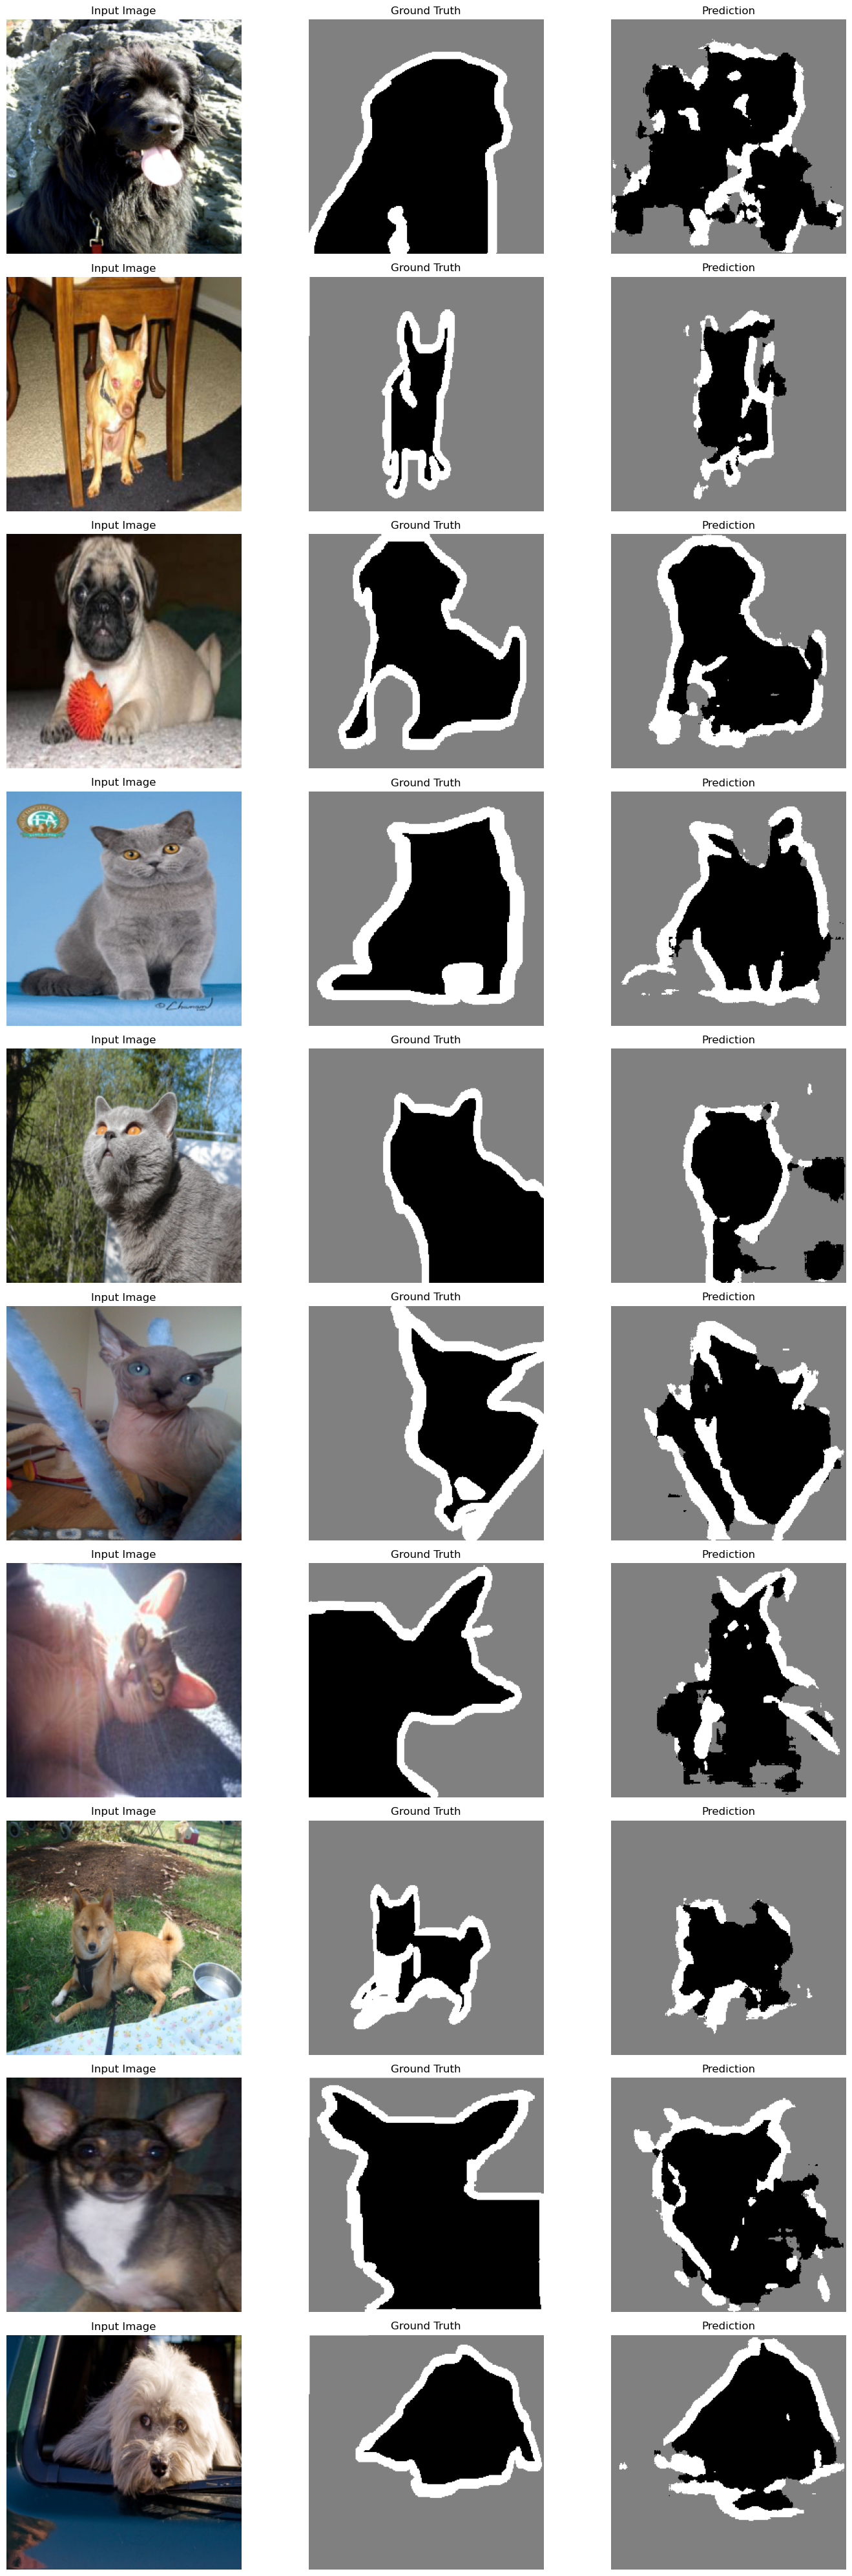

In [65]:
visualize_predictions(model, val_loader, device)

Random seed is set to 42 for reproducibility\
You've configured hyperparameters: 3 classes (background, pet, boundary), batch size of 8, learning rate of 1e-4, and 5 training epochs\

**Dataset Preparation**

ConvNeXt layers in the encoder path\
Skip connections between encoder and decoder\
A U-Net style architecture with downsampling and upsampling paths\

**Training**

Cross-entropy loss is used as the objective function\
Adam optimizer is used for training\

Tracked and displayed running loss during training\
Calculation of and display pixel accuracy and mean IoU metrics in validation\

**Results**

My model was achieving around 80-81% pixel accuracy and 57-58% mean IoU by the later epochs, showing decent performance on the pet segmentation task.
